# Final Project 

Team member: Lilo Yeh, Rohan Mewada

### Section 1

#### Introduction
Lithium-ion battery has been widely used in electric devices for its high energy density and excellent low temperature performance. The main challenge of Lithium-ion battery is its performance degradation and remaining useful life estimation. As a results, this final project focuses on lithium-ion battery remaining useful life estimation and prediction with NASA battery data set. Lithium-ion batteries were run through 3 different operational profiles(charge, discharge, and electrochemical impedance spectroscopy). In the NASA data set, the measured volage and current, the charged voltage and current in both charging and discharging cycle at different temperature are provided by the Prognostics CoE at NASA Ames.

#### Dataset origin:
Prognostics Data Repository is a collection of datasets that have been donated by agents.
This battery data set is provided by NASA Ames and collected from the experiment on Li-thium Battery
Prognostics PCoE Dataset: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/


#### Proposed Plan
We plan on using one of the models practiced during the course or exponential/logarithmic fitting. We will start by calculating the regression metrics for the models; 
1. Linear Regression
2. Ploynomial Regression
3. Exponential/logarithmic Regression
4. Neural Network

The purpose of plotting the regression metrics values is to identify the best fitting for the battery's capacity data. 

Once we identify the best fit, the next step will be to fit the model onto one of the battery's data, and use that to estimate the Rest Useful Life for the other batteries.

#### Model import

In [21]:
from scipy.io import loadmat, whosmat
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import os
import pandas as pd
from IPython.display import Image

%matplotlib inline

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


### Data Structure

Each battery data set is stored individually.  
Within each battery data set, three types of cycle were given which are 'discharge', 'charge' and 'impedance'.  
the structure is:  
    1. Type of cycle  
    2. Ambient temperature  
    3. Date time  
    4. Data: Corresponding data structure  
  
For 'Discharge', 'Charge' cycle, time series of voltage, current and temperature data was given.  
    1. Measured voltage   
    2. Measure current  
    3. Temperature  
    4. Load voltage  
    5. Load current  
    6. Time  
    7. Capacity single value (Discharge only)  
    
    
### Data Processing
The data have been storn in .mat file.  
To process the data, we need to extract the data from .mat file into different type of file.  
In order to index each cycle, we store the data in json file first and extract the content we need later on.  


In [22]:
def build_dictionaries(mess):

    discharge, charge, impedance = {}, {}, {}

    for i, element in enumerate(mess):

        step = element[0][0]

        if step == 'discharge':
            discharge[str(i)] = {}
            discharge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            discharge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            discharge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            discharge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            discharge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            discharge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            discharge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            discharge[str(i)]["time"] = data[0][0][5][0].tolist()
            discharge[str(i)]["Capacity"] = float(data[0][0][6][0][0])

        if step == 'charge':
            charge[str(i)] = {}
            charge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            charge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            charge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            charge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            charge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            charge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            charge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            charge[str(i)]["time"] = data[0][0][5][0].tolist()

        if step == 'impedance':
            impedance[str(i)] = {}
            impedance[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            impedance[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            impedance[str(i)]["sense_current"] = {}
            impedance[str(i)]["battery_current"] = {}
            impedance[str(i)]["current_ratio"] = {}
            impedance[str(i)]["battery_impedance"] = {}
            impedance[str(i)]["rectified_impedance"] = {}

            impedance[str(i)]["sense_current"]["real"] = np.real(data[0][0][0][0]).tolist()
            impedance[str(i)]["sense_current"]["imag"] = np.imag(data[0][0][0][0]).tolist()

            impedance[str(i)]["battery_current"]["real"] = np.real(data[0][0][1][0]).tolist()
            impedance[str(i)]["battery_current"]["imag"] = np.imag(data[0][0][1][0]).tolist()

            impedance[str(i)]["current_ratio"]["real"] = np.real(data[0][0][2][0]).tolist()
            impedance[str(i)]["current_ratio"]["imag"] = np.imag(data[0][0][2][0]).tolist()

            impedance[str(i)]["battery_impedance"]["real"] = np.real(data[0][0][3]).tolist()
            impedance[str(i)]["battery_impedance"]["imag"] = np.imag(data[0][0][3]).tolist()

            impedance[str(i)]["rectified_impedance"]["real"] = np.real(data[0][0][4]).tolist()
            impedance[str(i)]["rectified_impedance"]["imag"] = np.imag(data[0][0][4]).tolist()

            impedance[str(i)]["re"] = float(data[0][0][5][0][0])
            impedance[str(i)]["rct"] = float(data[0][0][6][0][0])
            
    return discharge, charge, impedance

In [23]:
def save_json(dictionary, name):
    with open(name + '.json', 'w') as f:
        json.dump(dictionary, f, indent=4)

In [4]:
folder = './' 
filenames = [f for f in os.listdir(folder) if f.endswith('.mat')]

for filename in filenames:
    name = filename.split('.mat')[0]
    print(name)
    struct = loadmat(folder + '/' + filename)
    mess = struct[name][0][0][0][0]
    
    discharge, charge, impedance = build_dictionaries(mess)
    
    save_json(discharge, name + '_discharge')
    save_json(charge, name + '_charge')    
    save_json(impedance, name + '_impedance') 

B0018
B0007
B0005
B0006


#### Battery 5 data Preprocessing and Visualization

After 4 battery data sets were completely extracted, we would start to select the data we need to store in DataFrame.

In [24]:
with open('./B0005_impedance.json') as f:    
    impedance_data_5 = json.load(f)
    
with open('./B0005_discharge.json') as f:    
    discharge_data_5 = json.load(f)

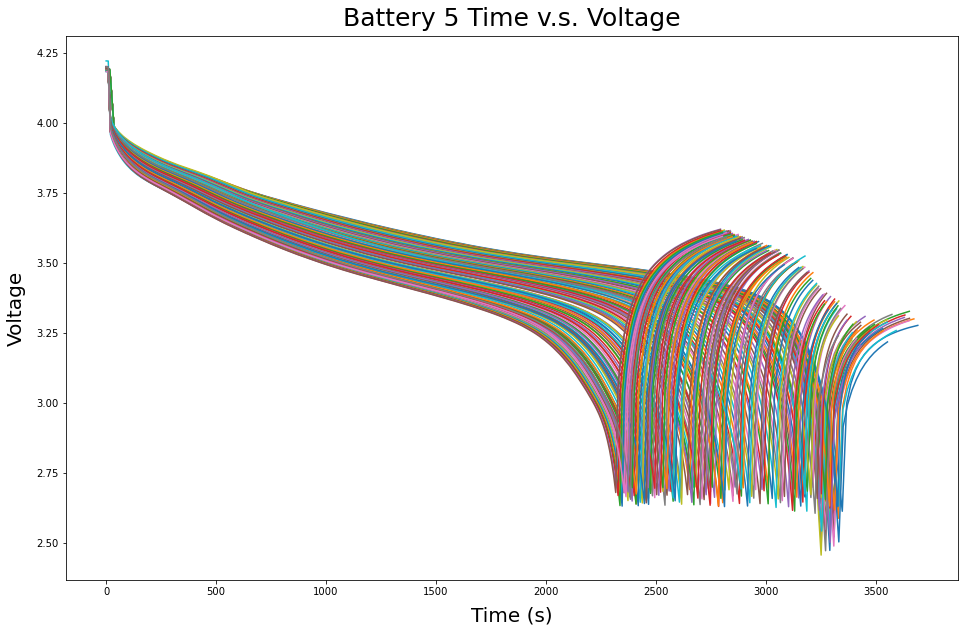

In [25]:
#Battery 5 time vs. voltage measured in each cycle
b5_t_voltage = plt.figure(figsize = (16,10))
for cycle in discharge_data_5.keys():
    plt.plot(discharge_data_5[cycle]["time"], discharge_data_5[cycle]['voltage_battery'], '-')
plt.ylabel('Voltage', fontsize = 20, labelpad = 10)
plt.xlabel('Time (s)', fontsize = 20, labelpad = 10)
plt.title('Battery 5 Time v.s. Voltage', fontsize = 25, pad = 10)
plt.show()
b5_t_voltage.savefig('B0005_t_voltage.png')

In this figure, we found out that the voltage discharge rate increase when the cycle number is larger.  
This phenomenon represents the nature of battery.  The capacity would degrade as the time went by.  

In [26]:
#Extract the data / hyperparameter we need for later training
#Naming of the DataFrame has been adjusted to suit for both polynomial regression model and NN model
cycle_5 = []
time_5 = []
voltage_5 = []
current_5 = []
temp_5 = []
capacity_5 = []

for i in discharge_data_5.keys():
    time_5.append(discharge_data_5[i]['time'][-1])
    voltage_5.append(discharge_data_5[i]['voltage_battery'][-1])
    current_5.append(discharge_data_5[i]['current_battery'][-1])
    temp_5.append(discharge_data_5[i]['temp_battery'][-1])
    capacity_5.append(discharge_data_5[i]['Capacity'])
    
for j in range(1, 169):
    cycle_5.append(j)

B005_test_data = pd.DataFrame({'cycle': cycle_5, 'Time Measured': time_5, 'Voltage Measured': voltage_5,
                          'Current Measured': current_5, 'Temperature': temp_5, 'capacity':capacity_5})
B005_test_data['index'] = B005_test_data.index

In [27]:
B005_test_data

,cycle,Time Measured,Voltage Measured,Current Measured,Temperature,capacity,index
0,1,3690.234,3.277170,-0.006528,34.230853,1.856487,0
1,2,3672.344,3.300245,-0.000448,34.392137,1.846327,1
2,3,3651.641,3.327451,0.001026,34.232779,1.835349,2
3,4,3631.563,3.314182,-0.002234,34.413450,1.835263,3
4,5,3629.172,3.305497,0.000009,34.345885,1.834646,4
...,...,...,...,...,...,...,...
163,164,2793.390,3.615561,-0.002548,34.075649,1.293464,163
164,165,2793.390,3.621191,-0.002460,33.991350,1.288003,164
165,166,2792.485,3.619185,0.000478,34.059198,1.287453,165
166,167,2802.016,3.595365,-0.002342,34.556514,1.309015,166


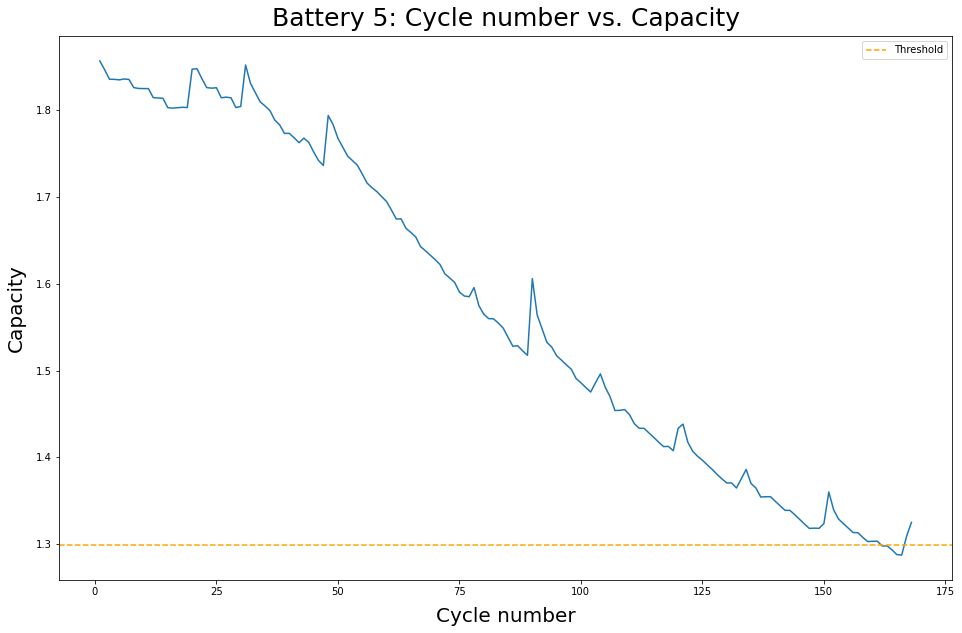

In [28]:
#Battery 5: Each cycle capacity visualization
cycle_5_capacity = plt.figure(figsize = (16,10))
plt.plot(B005_test_data['cycle'], B005_test_data['capacity'], '-')
plt.axhline(B005_test_data['capacity'][0]*0.7, color='orange', linestyle='--', label = 'Threshold')
plt.xlabel('Cycle number', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity', fontsize = 20, labelpad = 10)
plt.legend()
plt.title('Battery 5: Cycle number vs. Capacity', fontsize = 25, pad = 10)
cycle_5_capacity.savefig('cycle_5_capacity.png')

The above figure is representing the capacity degradation after hundreds of cycle.  
The reasons for the degradation are SEI (Solid Electrolyte Interface) layer formation and Electrolytic oxidation.    
With continuous charge and discharge cycles, coupled with material aging, battery performance declines.   
Remaining life of a Li-ion battery is defined as the number of cycles before the capacity falls under 70% of its original capacity. 
The battery will be tested until the capacity reaches the remaining useful life.
In other words, more charge - discharge cycle can be done, slower capacity degradation is.
  
Relaxation effect was found on the figure.  
Relaxation effect is a battery capacity regeneration phenomenon that occurs after a long period of rest.  

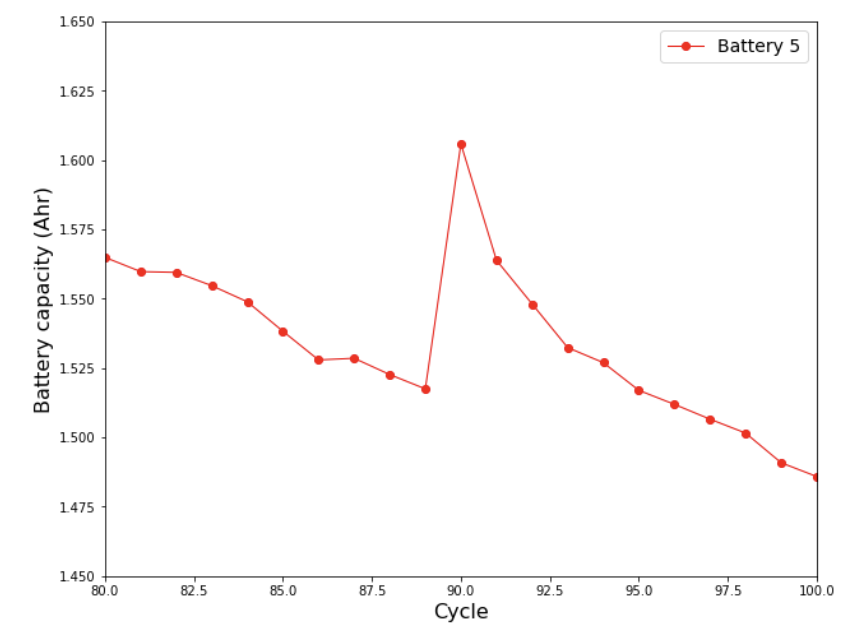

In [29]:
Image("Relaxation_effect.png")

#### Battery 6 data preprocessing and visualization

In [30]:
with open('./B0006_impedance.json') as f:    
    impedance_data_6 = json.load(f)
    
with open('./B0006_discharge.json') as f:    
    discharge_data_6 = json.load(f)

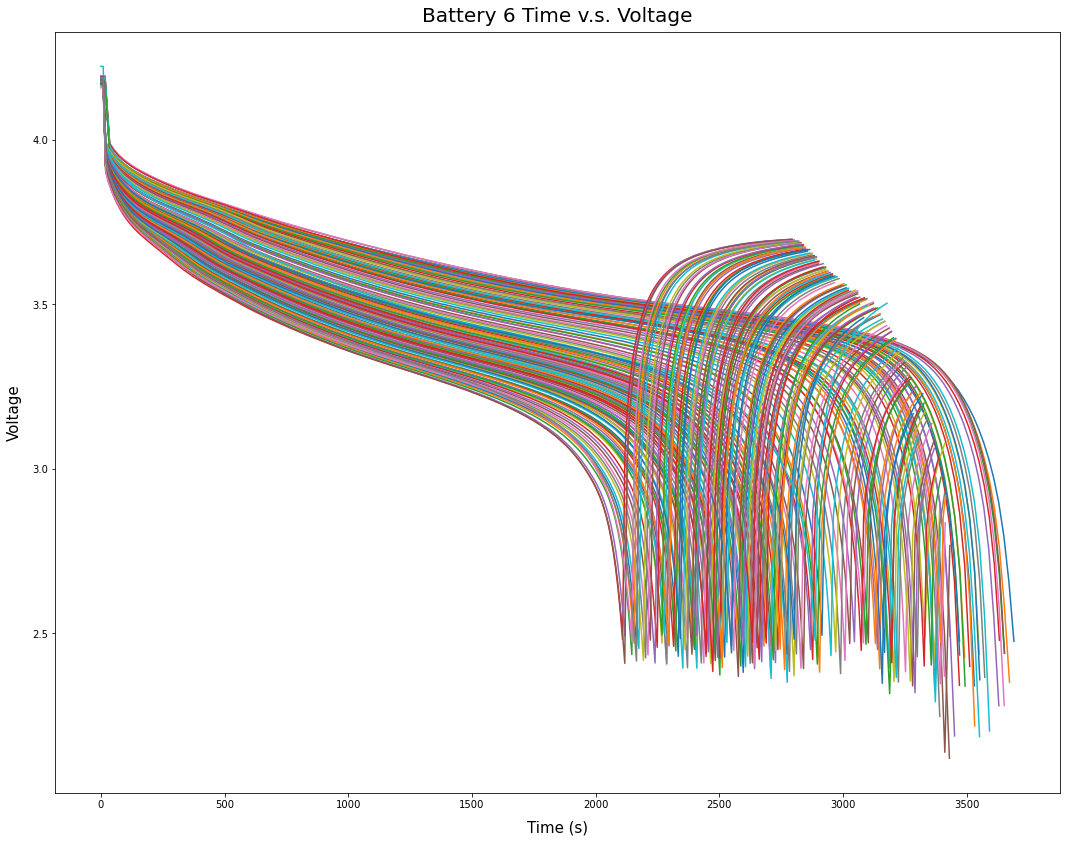

In [31]:
b6_t_voltage = plt.figure(figsize = (18,14))
for cycle in discharge_data_6.keys():
    plt.plot(discharge_data_6[cycle]["time"], discharge_data_6[cycle]['voltage_battery'], '-')
plt.ylabel('Voltage', fontsize = 15, labelpad = 10)
plt.xlabel('Time (s)', fontsize = 15, labelpad = 10)
plt.title('Battery 6 Time v.s. Voltage', fontsize = 20, pad = 10)
plt.show()
b6_t_voltage.savefig('B0006_t_voltage.png')

In [32]:
cycle_6 = []
time_6 = []
voltage_6 = []
current_6 = []
temp_6 = []
capacity_6 = []

for i in discharge_data_6.keys():
    time_6.append(discharge_data_6[i]['time'][-1])
    voltage_6.append(discharge_data_6[i]['voltage_battery'][-1])
    current_6.append(discharge_data_6[i]['current_battery'][-1])
    temp_6.append(discharge_data_6[i]['temp_battery'][-1])
    capacity_6.append(discharge_data_6[i]['Capacity'])
    
for j in range(1, 169):
    cycle_6.append(j)

B006_train_data = pd.DataFrame({'cycle': cycle_6, 'Time Measured': time_6, 'Voltage Measured': voltage_6,
                          'Current Measured': current_6, 'Temperature': temp_6, 'capacity':capacity_6})
B006_train_data['index'] = B006_train_data.index

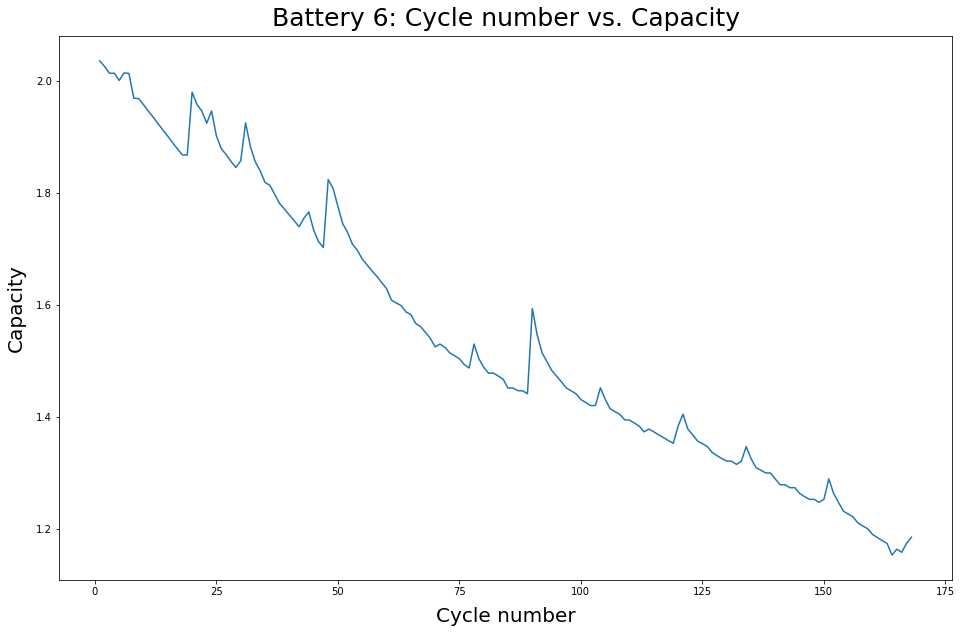

In [33]:
#Battery 6: Each cycle capacity visualization
cycle_6_capacity = plt.figure(figsize = (16,10))
plt.plot(B006_train_data['cycle'], B006_train_data['capacity'], '-')
plt.xlabel('Cycle number', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity', fontsize = 20, labelpad = 10)
plt.title('Battery 6: Cycle number vs. Capacity', fontsize = 25, pad = 10)
cycle_6_capacity.savefig('cycle_6_capacity.png')

#### Battery 7 data preprocessing and visualization

In [34]:
with open('./B0007_discharge.json') as f:
    discharge_data_7 = json.load(f)
    
with open('./B0007_impedance.json') as f:    
    impedance_data_7 = json.load(f)

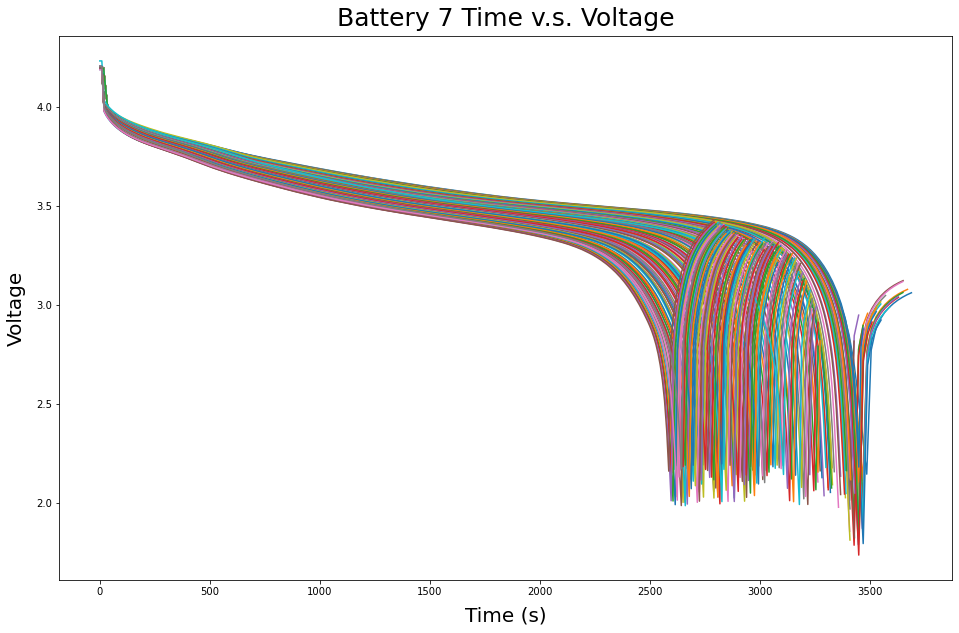

In [35]:
b7_t_voltage = plt.figure(figsize = (16,10))
for cycle in discharge_data_7.keys():
    plt.plot(discharge_data_7[cycle]["time"], discharge_data_7[cycle]['voltage_battery'], '-')
plt.ylabel('Voltage', fontsize = 20, labelpad = 10)
plt.xlabel('Time (s)', fontsize = 20, labelpad = 10)
plt.title('Battery 7 Time v.s. Voltage', fontsize = 25, pad = 10)
plt.show()
b7_t_voltage.savefig('B0007_t_voltage.png')

In [36]:
cycle_7 = []
time_7 = []
voltage_7 = []
current_7 = []
temp_7 = []
capacity_7 = []

for i in discharge_data_7.keys():
    time_7.append(discharge_data_7[i]['time'][-1])
    voltage_7.append(discharge_data_7[i]['voltage_battery'][-1])
    current_7.append(discharge_data_7[i]['current_battery'][-1])
    temp_7.append(discharge_data_7[i]['temp_battery'][-1])
    capacity_7.append(discharge_data_7[i]['Capacity'])
    
for j in range(1, 169):
    cycle_7.append(j)

B007_train_data = pd.DataFrame({'cycle': cycle_7, 'Time Measured': time_7, 'Voltage Measured': voltage_7,
                          'Current Measured': current_7, 'Temperature': temp_7, 'capacity':capacity_7})
B007_train_data['index'] = B007_train_data.index

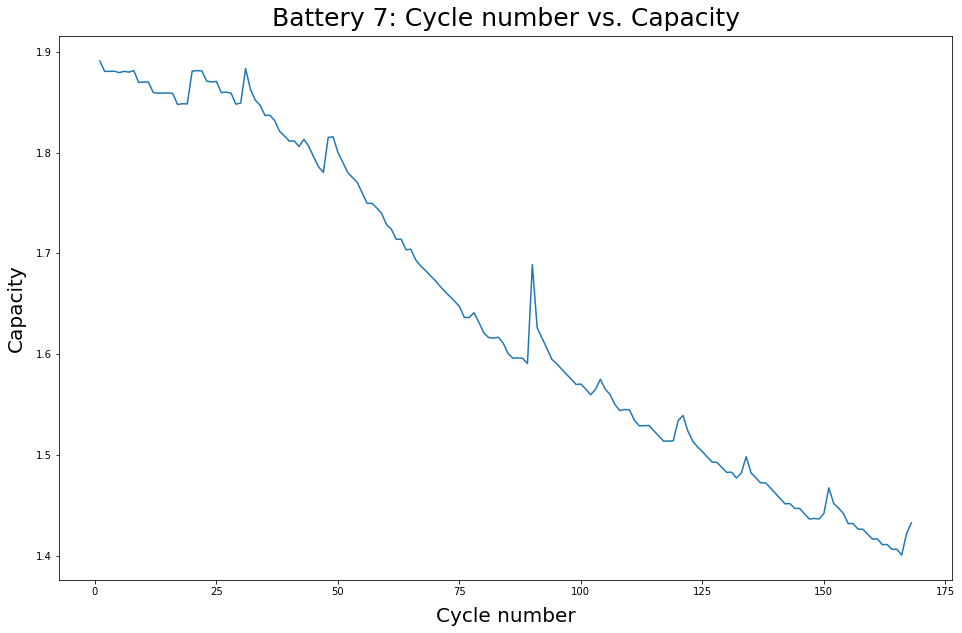

In [37]:
#Battery 7: Each cycle capacity visualization
cycle_7_capacity = plt.figure(figsize = (16,10))
plt.plot(B007_train_data['cycle'], B007_train_data['capacity'], '-')
plt.xlabel('Cycle number', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity', fontsize = 20, labelpad = 10)
plt.title('Battery 7: Cycle number vs. Capacity', fontsize = 25, pad = 10)
cycle_7_capacity.savefig('cycle_7_capacity.png')

#### Battery 18 data preprocessing and visualization

In [38]:
#Use battery 18 to predict the capacity
#Load the data first
with open('./B0018_discharge.json') as f:
    discharge_data_18 = json.load(f)
with open('./B0018_charge.json') as f:
    charge_data_18 = json.load(f)
with open('./B0018_impedance.json') as f:
    impedance_data_18 = json.load(f)

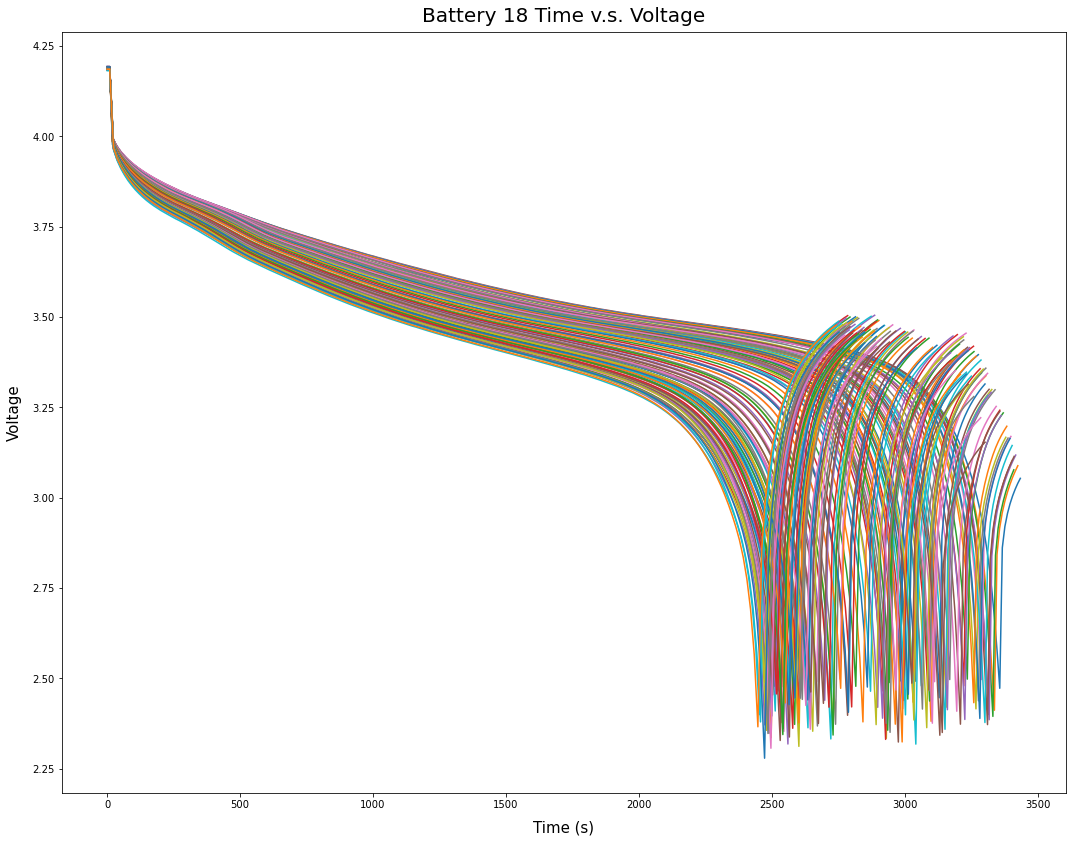

In [39]:
b18_t_voltage = plt.figure(figsize= (18, 14))

for cycle in discharge_data_18.keys():
    plt.plot(discharge_data_18[cycle]['time'], discharge_data_18[cycle]['voltage_battery'])
plt.ylabel('Voltage', fontsize = 15, labelpad = 10)
plt.xlabel('Time (s)', fontsize = 15, labelpad = 10)
plt.title('Battery 18 Time v.s. Voltage', fontsize = 20, pad = 10)
plt.show()
b18_t_voltage.savefig('B0018_t_voltage.png')

In [40]:
cycle_18 = []
time_18 = []
voltage_18 = []
current_18 = []
temp_18 = []
capacity_18 = []

for i in discharge_data_18.keys():
    time_18.append(discharge_data_18[i]['time'][-1])
    voltage_18.append(discharge_data_18[i]['voltage_battery'][-1])
    current_18.append(discharge_data_18[i]['current_battery'][-1])
    temp_18.append(discharge_data_18[i]['temp_battery'][-1])
    capacity_18.append(discharge_data_18[i]['Capacity'])
    
for j in range(1, 133):
    cycle_18.append(j)

B018_train_data = pd.DataFrame({'cycle': cycle_18, 'Time Measured': time_18, 'Voltage Measured': voltage_18,
                          'Current Measured': current_18, 'Temperature': temp_18, 'capacity':capacity_18})
B018_train_data['index'] = B018_train_data.index

In [41]:
#impedance data preprocessing
impedance_18_re = []
impedance_18_rct = []
cycle_18 = []

for i in impedance_data_18.keys():
    impedance_18_re.append(impedance_data_18[i]['re'])
    impedance_18_rct.append(impedance_data_18[i]['rct'])
    cycle_18.append(int(i))
    
data_18_imp = pd.DataFrame({'cycle1': cycle_18, 'Impedance Re': impedance_18_re, 'Impedance Rct': impedance_18_rct})

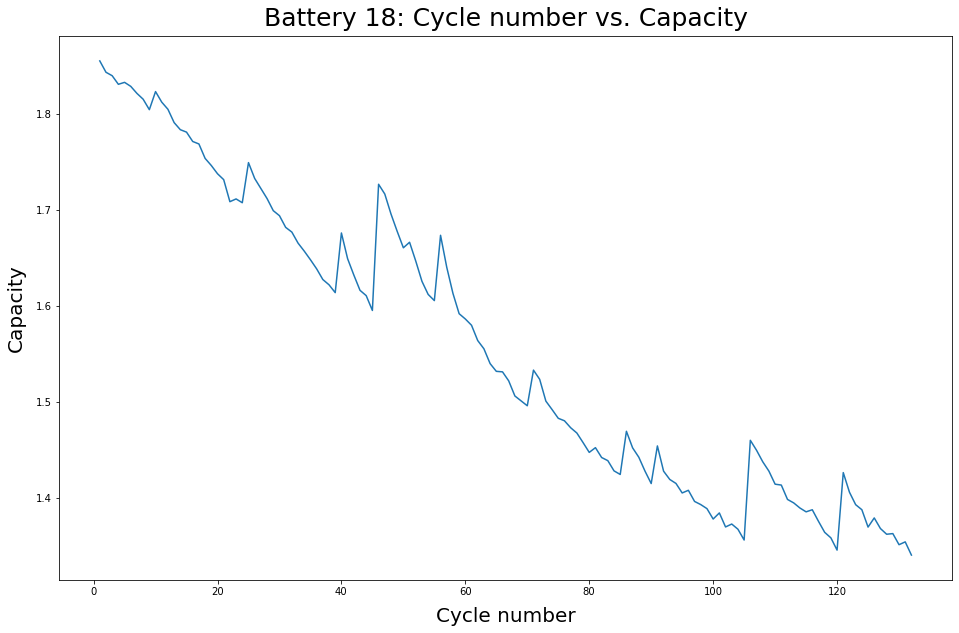

In [42]:
cycle_18_capacity = plt.figure(figsize = (16,10))
plt.plot(B018_train_data['cycle'], B018_train_data['capacity'], '-')
plt.xlabel('Cycle number', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity', fontsize = 20, labelpad = 10)
plt.title('Battery 18: Cycle number vs. Capacity', fontsize = 25, pad = 10)
cycle_18_capacity.savefig('cycle_18_capacity.png')

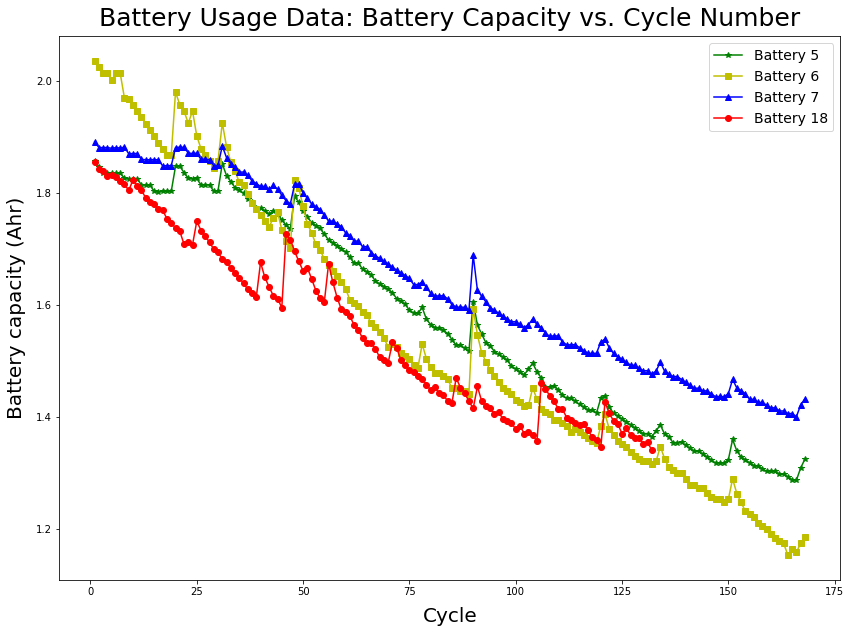

In [43]:
#Overall Cycle number vs. Capacity plotting
Batteries_cycle_capacity = plt.figure(figsize = (14, 10))
plt.plot(B005_test_data['cycle'], B005_test_data['capacity'], '-*', c = 'g', label = 'Battery 5')
plt.plot(B006_train_data['cycle'], B006_train_data['capacity'], '-s', c = 'y', label = 'Battery 6')
plt.plot(B007_train_data['cycle'], B007_train_data['capacity'], '-^', c = 'b', label = 'Battery 7')
plt.plot(B018_train_data['cycle'], B018_train_data['capacity'], '-o', c = 'r', label = 'Battery 18')
plt.xlabel('Cycle', fontsize = 20, labelpad = 10)
plt.ylabel('Battery capacity (Ahr)', fontsize = 20, labelpad = 10)
plt.legend(fontsize = 14)
plt.title('Battery Usage Data: Battery Capacity vs. Cycle Number', fontsize = 25, pad = 10)
Batteries_cycle_capacity.savefig('Batteries_cycle_capacity.png')

With different charge-discharge curve, here the overall capacity degradation is drawn.
In the above figure, battery 18 reached the remaining useful life earlier than other batterys and the cycle number is shorter.
Battery 5,6,7 reached their RUL at the same cycle.

## Section 2
### Polynomial linear regression

After finished the data preprocessing and visualization, we started to build the prediction model.  
We used the polynomial linear regression and selected features degree 5 first.
The reason to select polynominal linear regression is to more fit the local peak due to the relaxation effect. 

Feature X Matrix: cycle number  
Target Y Vector: capacity

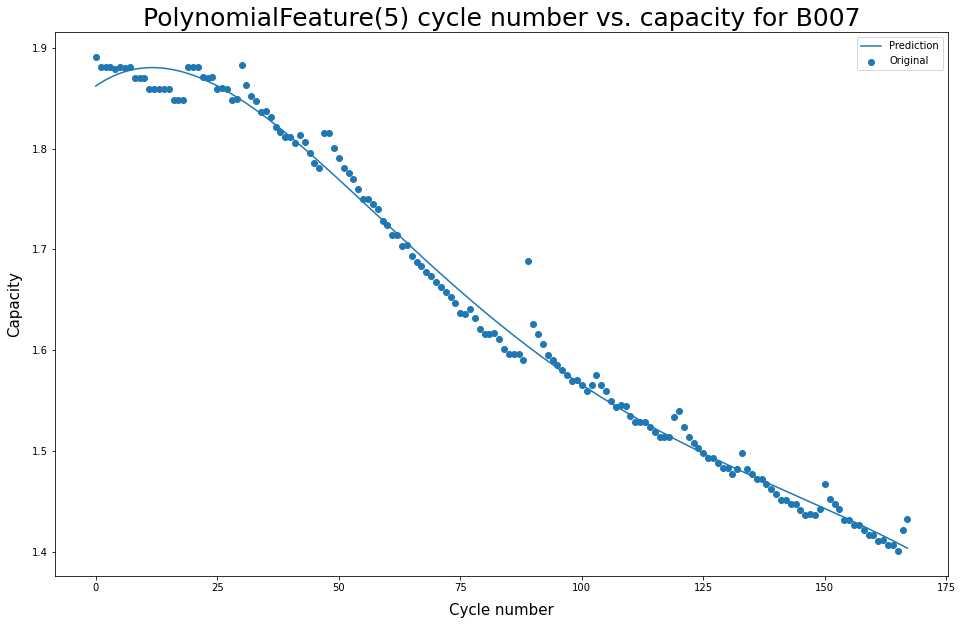

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

#Select the data set
X = B007_train_data[['index']]
Y = B007_train_data['capacity']
#Build a model
poly_model = PolynomialFeatures(5)
X2 = poly_model.fit_transform(X)
model2 = linear_model.LinearRegression()
model2.fit(X2, Y)

B007_degree5_poly = plt.figure(figsize = (16,10))
plt.scatter(X, Y, label = 'Original')
plt.plot(X, model2.predict(X2), label = 'Prediction')
plt.show
plt.title('PolynomialFeature(5) cycle number vs. capacity for B007', fontsize = 25)
plt.xlabel('Cycle number', fontsize = 15, labelpad = 10)
plt.ylabel('Capacity', fontsize = 15, labelpad = 10)
plt.legend()
B007_degree5_poly.savefig('B007_degree5_poly.png')

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
print('MSE score:', mean_squared_error(Y, model2.predict(X2)), 'R2 score:', r2_score(Y, model2.predict(X2)))

MSE score: 0.00020469164203577238 R2 score: 0.9920510618827034


After we first build the polynomial model, another battery data set was used to predict and test the model trained by battery 7

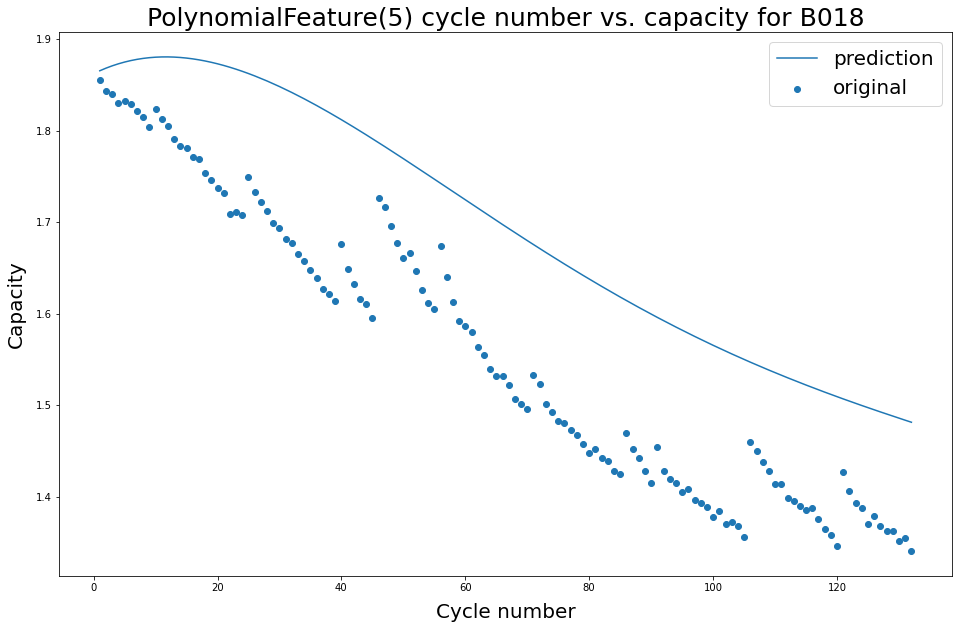

In [47]:
#Use Battery 18 to test if the MSE improve or not

#Select Battery 18 data set
X2_1 = B018_train_data[['cycle']]
Y_2 = B018_train_data['capacity']
#Fit for polynomial feature 7
poly_model = PolynomialFeatures(5)
X2_2 = poly_model.fit_transform(X2_1)
#Re-exam the model 2
B018_degree5_poly = plt.figure(figsize = (16,10))
plt.scatter(X2_1, Y_2, label = 'original')
plt.plot(X2_1, model2.predict(X2_2), label = 'prediction')
plt.title('PolynomialFeature(5) cycle number vs. capacity for B018', fontsize = 25)
plt.xlabel('Cycle number', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity', fontsize = 20, labelpad = 10)
plt.legend(fontsize = 20)
B018_degree5_poly.savefig('B018_degree5_poly.png')

In [48]:
from sklearn.metrics import mean_squared_error, r2_score
print('MSE:', mean_squared_error(Y_2, model2.predict(X2_2)), 'R2 score:', r2_score(Y_2, model2.predict(X2_2)))

MSE: 0.02107011458662561 R2 score: 0.11498018595629955


The polynomial feature model is able to predict capacity of the train battery but it can not predict other battery.
Therefore, we break down several way to improve the model from small to large.

### 3 Model improvement
#### Hypothesis:
#### 1. Tune optimal polynomial feature degree
Form a for loop to test optimal polynomial degree for the minimum of MSE value and maximum of R2 score  
Since the curve contains small peak, degree number may affect the end results.  
#### 2. Use different model: Exponential Regression
Utilize different regression function to build the model to investigate if it is because the linear regression.
Exponential function is a curve-like function and may be best to fit the capacity degradation curve.
#### 3. Use different hyperparameter
Single metric 'cycle number' may not be able to further improve the model properly.
Select and add another hyperparameter to train the model.
In order to train the model with a list of hyproparameter, neural network was built to take over the task.

### Model improvement 1: Tune optimal polynomial feature degree

Degree: 1 MSE: 0.0006099873687933641 R2 score: 0.9763119207084009
Degree: 2 MSE: 0.0005481969104274675 R2 score: 0.9787114741288774
Degree: 3 MSE: 0.0003115974899109536 R2 score: 0.9878995100133388
Degree: 4 MSE: 0.00020674258622064627 R2 score: 0.991971416088447
Degree: 5 MSE: 0.00020469164203577238 R2 score: 0.9920510618827034
Degree: 6 MSE: 0.0001661523985961082 R2 score: 0.9935476841098864
Degree: 7 MSE: 0.0001500189975530935 R2 score: 0.9941742041047285
Degree: 8 MSE: 0.000159430482209394 R2 score: 0.9938087211354153
Degree: 9 MSE: 0.00016041172005428457 R2 score: 0.9937706160187147
Degree: 10 MSE: 0.00015016595046081502 R2 score: 0.9941684973765103
Degree: 11 MSE: 0.0001740118262927176 R2 score: 0.9932424732875178
Degree: 12 MSE: 0.00029937317684684703 R2 score: 0.988374225576254
Degree: 13 MSE: 0.0005573420880319862 R2 score: 0.9783563328533128
Degree: 14 MSE: 0.0026022840948379694 R2 score: 0.8989436255053487
Degree: 15 MSE: 0.00327618108776749 R2 score: 0.8727736977010037
Degr

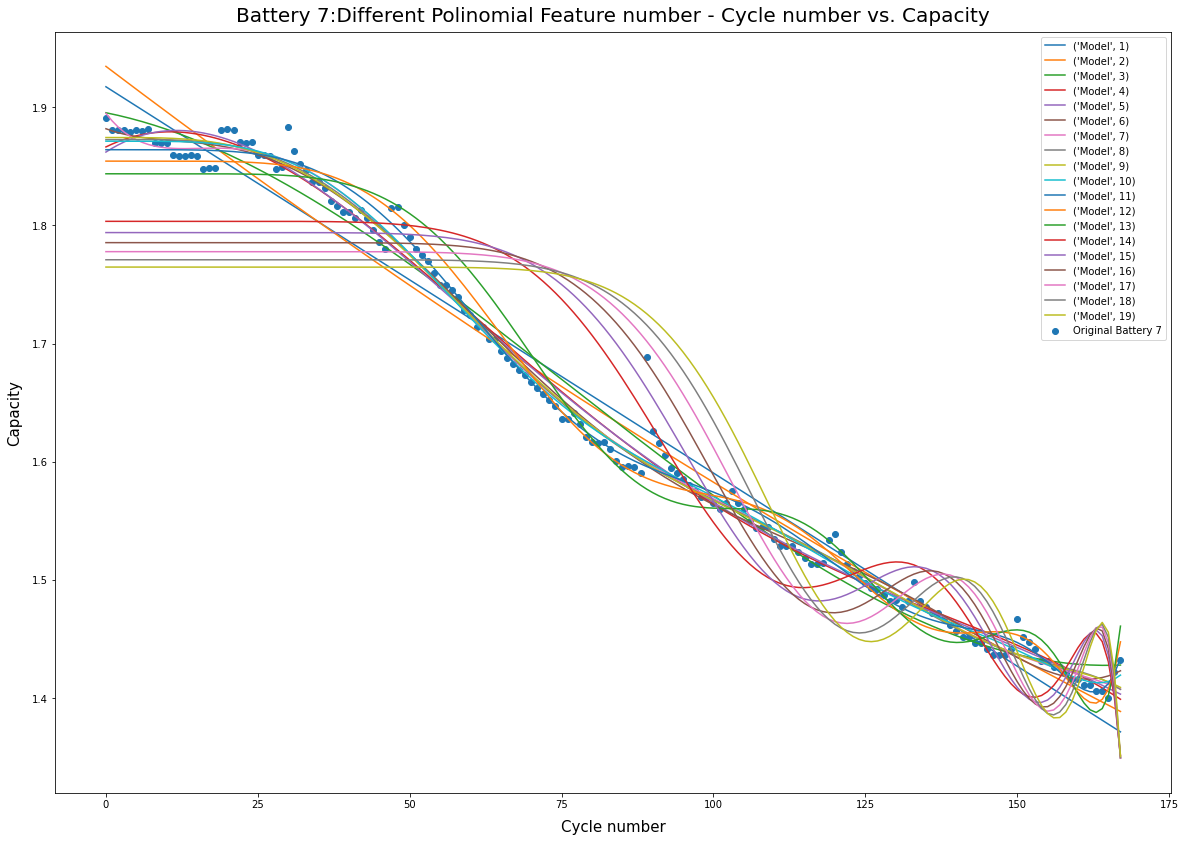

In [50]:
#Set up a for loop to gain the optimal degree number

optimal_poly = plt.figure(figsize = (20, 14))

degree = []
MSE = []
R2 = []

for i in range(1,20):
    poly_optimal_model = PolynomialFeatures(i)
    X2 = poly_optimal_model.fit_transform(X)
    linear_model = LinearRegression()
    linear_model.fit(X2, Y)
    plt.plot(X, linear_model.predict(X2), label = ('Model', i))
    degree.append(int(i))
    MSE.append(mean_squared_error(Y, linear_model.predict(X2)))
    R2.append(r2_score(Y, linear_model.predict(X2)))
    print('Degree:', i, 'MSE:', mean_squared_error(Y, linear_model.predict(X2)), 'R2 score:', r2_score(Y, linear_model.predict(X2)))
plt.scatter(X, Y, label = 'Original Battery 7')
plt.legend()
plt.xlabel('Cycle number', fontsize = 15, labelpad = 10)
plt.ylabel('Capacity', fontsize = 15, labelpad = 10)
plt.title('Battery 7:Different Polinomial Feature number - Cycle number vs. Capacity', fontsize = 20, pad = 10)
optimal_poly.savefig('B007_Optimal_Poly_number.png')

In [51]:
optimal_number = pd.DataFrame({'degree': degree, 'MSE': MSE, 'R2': R2})

In [52]:
optimal_number

,degree,MSE,R2
0,1,0.000610,0.976312
1,2,0.000548,0.978711
2,3,0.000312,0.987900
3,4,0.000207,0.991971
4,5,0.000205,0.992051
5,6,0.000166,0.993548
6,7,0.000150,0.994174
7,8,0.000159,0.993809
8,9,0.000160,0.993771
9,10,0.000150,0.994168


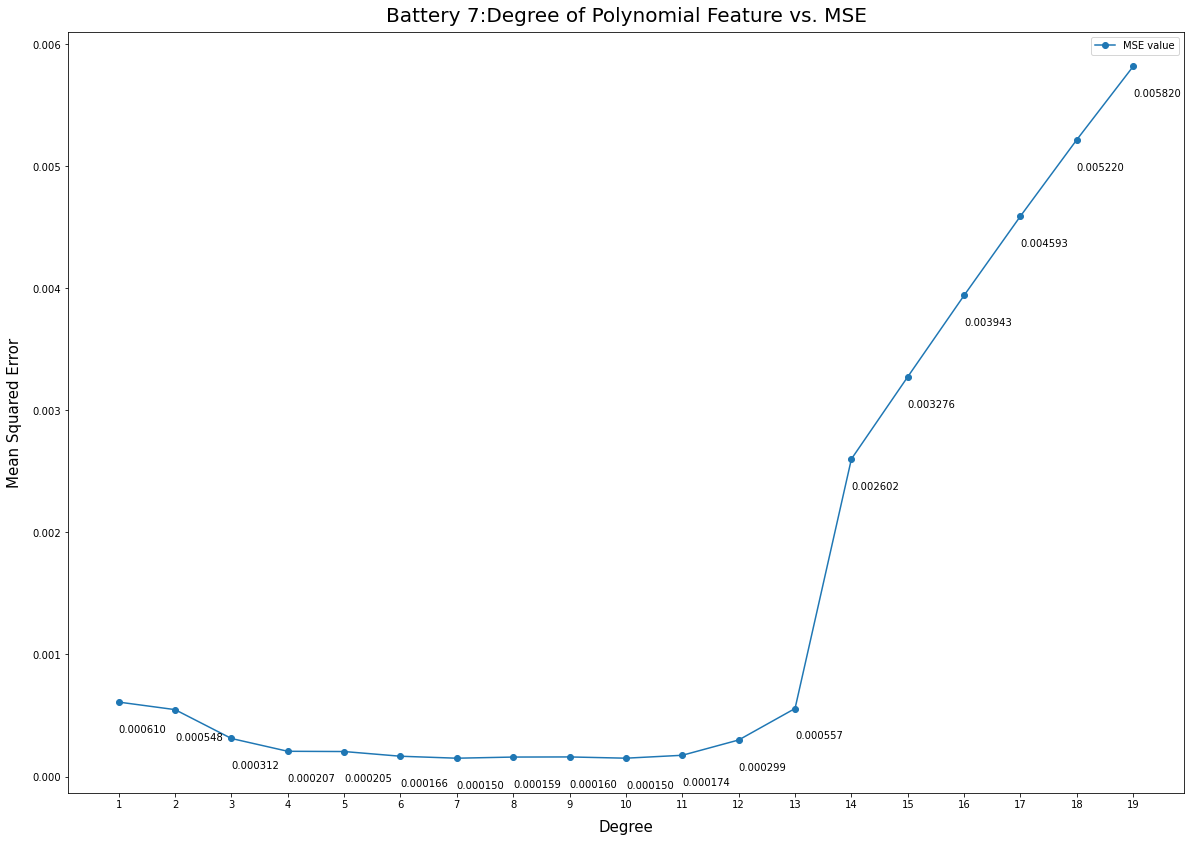

In [53]:
degree_MSE = plt.figure(figsize = (20, 14))
plt.plot(optimal_number['degree'], optimal_number['MSE'], '-o', label = 'MSE value')
for i in optimal_number.index:
    plt.text(optimal_number['degree'][i], optimal_number['MSE'][i]-0.00025, format(optimal_number['MSE'][i], ".6f"))
plt.legend()
plt.xlabel('Degree', fontsize = 15, labelpad = 10)
plt.ylabel('Mean Squared Error', fontsize = 15, labelpad = 10)
plt.xticks(range(1,20, 1))
plt.title('Battery 7:Degree of Polynomial Feature vs. MSE', fontsize = 20, pad = 10)
degree_MSE.savefig('B007_Optimal_degree_MSE.png')

Minimum MSE occurs when degree number is 7.  
After getting the number 7, train the polynomial regression model with optimal number again and test the accuracy.

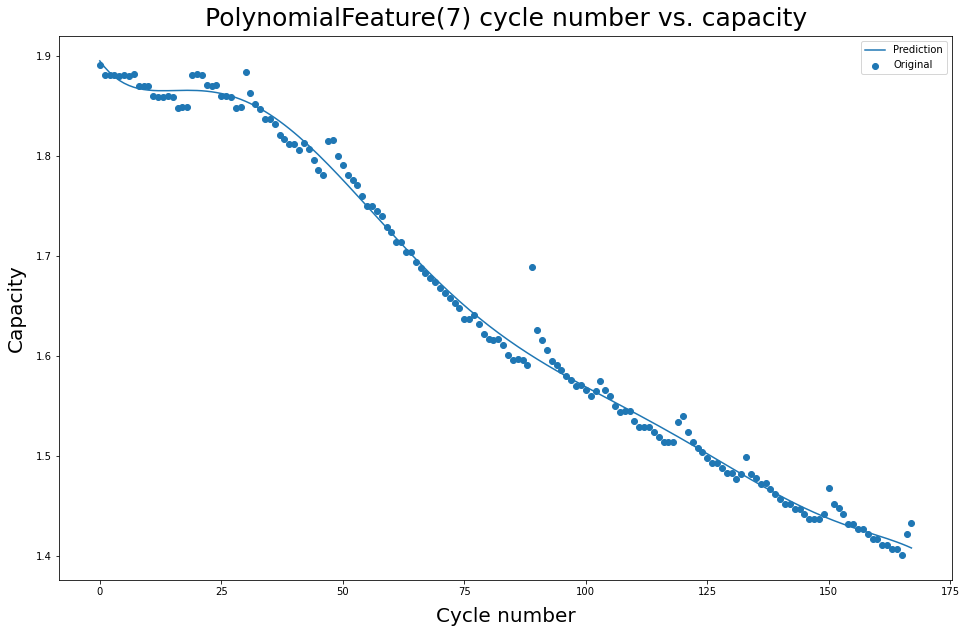

In [54]:
#Use the optimal polyfeature degree number 7 to train model again

#Build a model
poly_model = PolynomialFeatures(7)
X2 = poly_model.fit_transform(X)

model3 = LinearRegression()
model3.fit(X2, Y)

plt.figure(figsize = (16,10))
plt.scatter(X, Y, label = 'Original')
plt.plot(X, model3.predict(X2), label = 'Prediction')
plt.show
plt.title('PolynomialFeature(7) cycle number vs. capacity', fontsize = 25, pad = 10)
plt.xlabel('Cycle number', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity', fontsize = 20, labelpad = 10)
plt.legend()

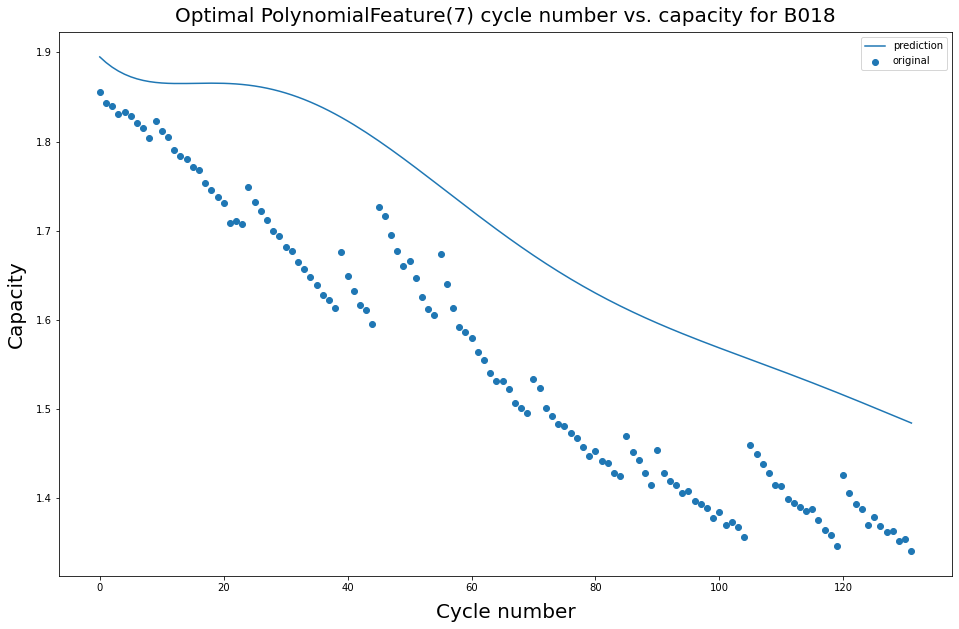

In [55]:
#Use Battery 18 to test if the MSE improve or not

#Select Battery 18 data set
X2_1 = B018_train_data[['index']]
Y_2 = B018_train_data['capacity']
#Fit for polynomial feature 7
poly_model = PolynomialFeatures(7)
X2_2 = poly_model.fit_transform(X2_1)
#Re-exam the model 2
b0018_optimal_degree = plt.figure(figsize = (16,10))
plt.scatter(X2_1, Y_2, label = 'original')
plt.plot(X2_1, model3.predict(X2_2), label = 'prediction')
plt.title('Optimal PolynomialFeature(7) cycle number vs. capacity for B018', fontsize = 20, pad = 10)
plt.xlabel('Cycle number', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity', fontsize = 20, labelpad = 10)
plt.legend()
b0018_optimal_degree.savefig('b0018_optimal_degree.png')

In [56]:
#Check the MSE value and R2 value with the trained model and optimal degree
from sklearn.metrics import mean_squared_error, r2_score
print('MSE:', mean_squared_error(Y_2, model3.predict(X2_2)), 'R2 score:', r2_score(Y_2, model3.predict(X2_2)))

MSE: 0.02215697155291507 R2 score: 0.06932832458445104


#### Found out optimal polynomial feature degree
Even though we found out the optimal degree, the model still can not be further improved.
That is to say, we turned out to include other factor to improve the model.

### Model improvement 2 : Use different model: Exponential Regression

The equation of regression line is y=1.921*0.9976^x


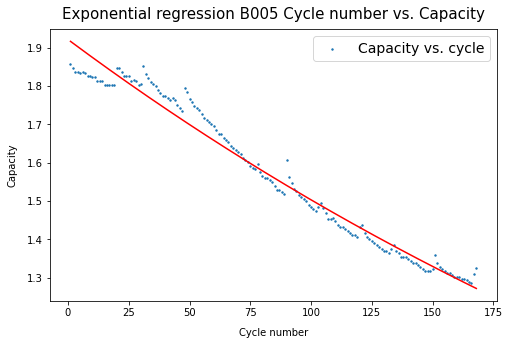

In [57]:
x1 = B005_test_data['cycle']
X1 = B005_test_data[['cycle']]
y1 = B005_test_data['capacity']
model_l = LinearRegression()
model_l.fit(X1, y1)


from scipy.optimize import curve_fit

def expo_func(x, a, b):
    return a * b ** x 

popt, pcov = curve_fit(expo_func, x1, y1)
y1_pred = expo_func(x1, popt[0], popt[1])

a=popt[0].round(4)
b=popt[1].round(4)
print(f'The equation of regression line is y={a}*{b}^x')
exponential_regression_B005 = plt.figure(figsize = (8,5))
plt.plot(x1, y1_pred, 'r-')
plt.scatter(x1, y1, s = 2, label = 'Capacity vs. cycle')
plt.legend(fontsize = 14)
plt.xlabel('Cycle number', fontsize = 10, labelpad = 10)
plt.ylabel('Capacity', fontsize = 10, labelpad = 10)
plt.title('Exponential regression B005 Cycle number vs. Capacity', fontsize = 15, pad = 10)
plt.show()
exponential_regression_B005.savefig('exponentional_B005.png')

In [58]:
print('MSE:', mean_squared_error(y1, y1_pred), 'R2 score:', r2_score(y1, y1_pred))

MSE: 0.0009637125690833307 R2 score: 0.9732608136840601


The MSE of Exponential Regression is higher than the Polynomial Regression

### Model improvement 3: implement Neural Network

To further improve the model, we start to implement neural network.  First of all, cycle number is the only hyperparameter in the above model.  It would be more precise and convincing if we take other factors into account.  Here we treat Battery6, Battery7 and Battery18 to be the train data and select Battery5 to be the test data.  In this way, we are able to exam the model accuracy and use the model to predict capacity in the future application.  

we train the model with three batteries and test the model with battery 5

### Train data:
B006_train_data  
B007_train_data  
B018_train_data  
### Test data:
B005_test_data  

### Input Parameters Considered

The input parameters considered to predict the capacity for the 3 batteries are: 
1. Cycle Number
2. Time Measured
3. Voltage Measured
4. Current Measured
5. Temperature

The values of the mentioed parameters were extracted for the last value of every discharge cycle, since that is when the respective cycle's capacity is obtained. Considering voltage, current, and temperature also brings in the factor of impedance.

The Relaxation Effect is also taken into account since we are also considering time as one of the input parameters.

In [59]:
#Combine all the train data
train_data = pd.concat([B006_train_data, B007_train_data, B018_train_data])

In [60]:
train_data

,cycle,Time Measured,Voltage Measured,Current Measured,Temperature,capacity,index
0,1,3690.234,2.475768,-2.009436,39.162987,2.035338,0
1,2,3672.344,2.351526,-2.010375,39.246203,2.025140,1
2,3,3651.641,2.440480,-2.008559,38.999202,2.013326,2
3,4,3631.563,2.479156,-2.009290,38.843628,2.013285,3
4,5,3629.172,2.280188,-2.011761,38.977989,2.000528,4
...,...,...,...,...,...,...,...
127,128,2777.844,3.459275,-0.003451,35.173858,1.362737,127
128,129,2781.125,3.484329,-0.001341,34.924706,1.363405,128
129,130,2760.906,3.481461,0.002415,34.805982,1.351865,129
130,131,2753.250,3.457732,0.000029,35.081770,1.354797,130


In [61]:
test_data = B005_test_data
test_data

,cycle,Time Measured,Voltage Measured,Current Measured,Temperature,capacity,index
0,1,3690.234,3.277170,-0.006528,34.230853,1.856487,0
1,2,3672.344,3.300245,-0.000448,34.392137,1.846327,1
2,3,3651.641,3.327451,0.001026,34.232779,1.835349,2
3,4,3631.563,3.314182,-0.002234,34.413450,1.835263,3
4,5,3629.172,3.305497,0.000009,34.345885,1.834646,4
...,...,...,...,...,...,...,...
163,164,2793.390,3.615561,-0.002548,34.075649,1.293464,163
164,165,2793.390,3.621191,-0.002460,33.991350,1.288003,164
165,166,2792.485,3.619185,0.000478,34.059198,1.287453,165
166,167,2802.016,3.595365,-0.002342,34.556514,1.309015,166


In [62]:
#Select train data
X1_train = train_data.iloc[:,0:5].values
y1_train = train_data.iloc[:,5].values

X1_005 = test_data.iloc[:,0:5].values
y1_005 = test_data.iloc[:,5].values

In [63]:
X1_train

array([[ 1.00000000e+00,  3.69023400e+03,  2.47576776e+00,
        -2.00943589e+00,  3.91629865e+01],
       [ 2.00000000e+00,  3.67234400e+03,  2.35152551e+00,
        -2.01037486e+00,  3.92462027e+01],
       [ 3.00000000e+00,  3.65164100e+03,  2.44047972e+00,
        -2.00855889e+00,  3.89992025e+01],
       ...,
       [ 1.30000000e+02,  2.76090600e+03,  3.48146072e+00,
         2.41523544e-03,  3.48059821e+01],
       [ 1.31000000e+02,  2.75325000e+03,  3.45773221e+00,
         2.94627686e-05,  3.50817702e+01],
       [ 1.32000000e+02,  2.74284300e+03,  3.47727674e+00,
        -1.94006858e-03,  3.45816595e+01]])

In [64]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_005 = sc.transform(X1_005)

In [65]:
#Check the dimension of X1_train data
X1_train.shape

(468, 5)

In [66]:
#Build the model
def model():
    model = Sequential()
    model.add(Dense(10, kernel_initializer = 'uniform', input_dim=X1_train.shape[1], activation='relu'))
    model.add(Dense(5, kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'uniform',activation = 'relu'))
    model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics= ['mean_absolute_error'])
    return model

In [67]:
estimator = KerasRegressor(build_fn=model)
history = estimator.fit(X1_train, y1_train, batch_size = 1, epochs = 20, verbose = 10)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [68]:
train = pd.DataFrame(history.history)
train.head()

,loss,mean_absolute_error
0,0.664422,0.563844
1,0.007715,0.064667
2,0.002918,0.038295
3,0.001651,0.028816
4,0.001267,0.025388


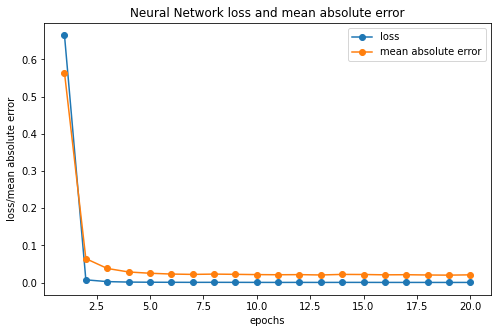

In [69]:
NN_loss_error = plt.figure(figsize = (8, 5))
plt.plot(np.linspace(1, 20, 20), train.loss, '-o', label = 'loss')
plt.plot(np.linspace(1, 20, 20), train.mean_absolute_error, '-o', label = 'mean absolute error')
plt.xlabel('epochs')
plt.ylabel('loss/mean absolute error')
plt.legend()
plt.title('Neural Network loss and mean absolute error')
NN_loss_error.savefig('NN_loss_error.png')

In [70]:
y1_pred = estimator.predict(X1_005)

In [71]:
y1_pred

array([1.8396126, 1.831132 , 1.8173188, 1.8141118, 1.8132627, 1.8147597,
       1.8154224, 1.7964652, 1.795359 , 1.7958273, 1.7961676, 1.7812188,
       1.7833184, 1.7810513, 1.7623161, 1.762181 , 1.7658637, 1.7695758,
       1.7702307, 1.7906022, 1.7998624, 1.7784841, 1.762373 , 1.7613779,
       1.7699976, 1.7465466, 1.7532737, 1.7543896, 1.7315457, 1.739744 ,
       1.7557896, 1.7429698, 1.7303953, 1.7145543, 1.7127806, 1.709789 ,
       1.6936008, 1.6896404, 1.6771498, 1.6865169, 1.68454  , 1.6795976,
       1.6821438, 1.6680827, 1.6573408, 1.6475874, 1.6432979, 1.7237885,
       1.6953471, 1.6751243, 1.6668694, 1.6522566, 1.6499888, 1.6498517,
       1.636099 , 1.6242144, 1.6209773, 1.6172129, 1.6162025, 1.6088635,
       1.5996865, 1.5873276, 1.5942854, 1.5801997, 1.5799783, 1.5771904,
       1.5658015, 1.5628328, 1.5584443, 1.556429 , 1.5531182, 1.5404733,
       1.5394729, 1.5372794, 1.5245746, 1.5216326, 1.5191879, 1.5285245,
       1.5077153, 1.5001922, 1.4987999, 1.5044806, 

In [72]:
y1_005

array([1.85648742, 1.84632725, 1.83534919, 1.83526253, 1.83464551,
       1.83566166, 1.83514614, 1.82575679, 1.82477385, 1.82461327,
       1.82461955, 1.81420194, 1.81375216, 1.81344049, 1.802598  ,
       1.8021069 , 1.8025795 , 1.80306831, 1.80277762, 1.84702599,
       1.84741731, 1.83617742, 1.82578075, 1.82511364, 1.8255815 ,
       1.81403113, 1.81476919, 1.81396939, 1.80276567, 1.80407704,
       1.85180255, 1.83070385, 1.81990411, 1.80930796, 1.8046099 ,
       1.79937707, 1.78844323, 1.78292305, 1.77303372, 1.77303776,
       1.76787211, 1.76231507, 1.76761729, 1.76266836, 1.75173049,
       1.7418496 , 1.73609135, 1.79362401, 1.78318902, 1.76736421,
       1.75701779, 1.74687062, 1.74171725, 1.73642251, 1.72632172,
       1.71580654, 1.71053335, 1.7060145 , 1.70031103, 1.69457986,
       1.68490291, 1.67447416, 1.67456925, 1.66371638, 1.65901387,
       1.65385406, 1.64265378, 1.63785784, 1.63273504, 1.62775289,
       1.62212549, 1.61132566, 1.60656314, 1.60151422, 1.59036

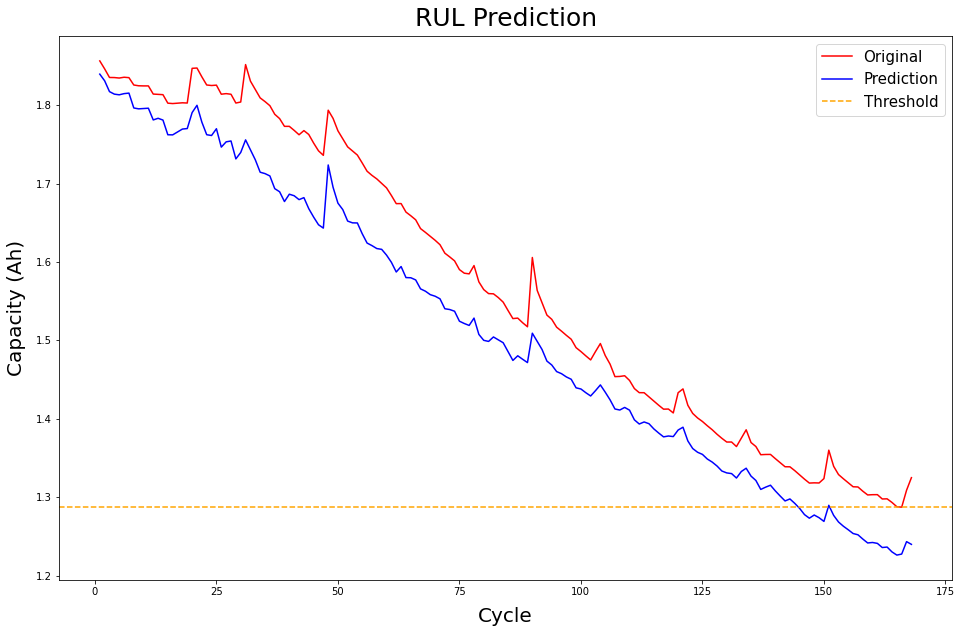

In [73]:
import matplotlib.pyplot as plt
NN_prediction = plt.figure(figsize = (16, 10))
x_inp = []
for i in range(1,len(y1_pred)+1):
    x_inp.append(i)
plt.plot(x_inp, y1_005, color='red', label = 'Original')
plt.plot(x_inp, y1_pred, color='blue', label = 'Prediction')
plt.axhline(y1_pred[0]*0.7, color='orange', linestyle='--', label = 'Threshold')
plt.title('RUL Prediction', fontsize = 25, pad = 10)
plt.xlabel('Cycle', fontsize = 20, labelpad = 10)
plt.ylabel('Capacity (Ah)', fontsize = 20, labelpad = 10)
plt.legend(fontsize = 15)
plt.show()
NN_prediction.savefig('NN_prediction.png')

In [74]:
#Check the MSE of Battery 5 Neural Network prediction 
print('MSE:', mean_squared_error(y1_005, y1_pred), 'R2 score:', r2_score(y1_005, y1_pred))

MSE: 0.0037730740184277545 R2 score: 0.8953122202623799


## Conclusions:

We successfully build out a neural network model with R2 score 0.9157 and MSE 0.003035!
With this model, we are able to apply measured voltage, current, temperature to predict capacity. The small increments in the plot are due to the capacity relaxation, which happens when the battery was kept idle for an extended period of time. Including the factor of time as an input in the neural network allows us to even predict those random peaks. Hence, the developed model can help predict the remaining useful life of the li-ion battery upto a reasonable extent. Keeping track of the degradation of the battery also improves the safety of the device, since we can potentially predict the degradation trend